# Posterior uncertainties

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from odefilter import dense_output, ivpsolve, solvers
from odefilter.strategies import filters, smoothers

config.update("jax_enable_x64", True)

if not backend.has_been_selected:
    backend.select("jax")

Set an example problem.

In [2]:
f, u0, (t0, t1), f_args = ivps.lotka_volterra()


@jax.jit
def vf(*ys, t, p):
    return f(*ys, *p)

## Filter

Low resolution and short time-span to achieve large uncertainty and only few steps.

In [3]:
ts0 = solvers.MLESolver(strategy=filters.Filter.from_params())
ts = jnp.linspace(t0, t0 + 2.0, endpoint=True, num=500)

In [4]:
%%time

solution = ivpsolve.simulate_checkpoints(
    vf, initial_values=(u0,), ts=ts, solver=ts0, rtol=1e-1, atol=1e-1, parameters=f_args
)

CPU times: user 2.95 s, sys: 11.4 ms, total: 2.96 s
Wall time: 2.86 s


Plot the solution

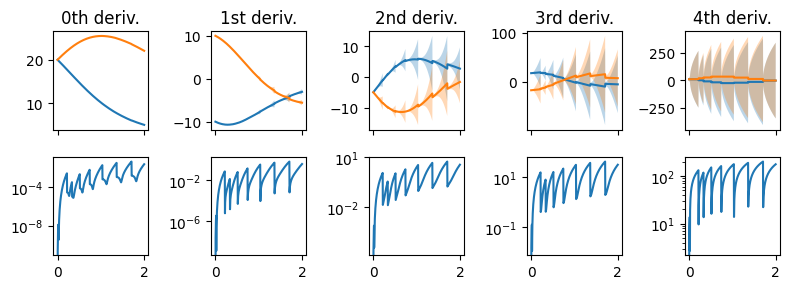

In [5]:
_, num_derivatives, _ = solution.marginals.mean.shape


fig, axes_all = plt.subplots(
    nrows=2,
    ncols=num_derivatives,
    sharex=True,
    tight_layout=True,
    figsize=(8, 3),
)

for i, axes_cols in enumerate(axes_all.T):
    ms = solution.marginals.mean[:, i, :]
    ls = solution.marginals.cov_sqrtm_lower[:, i, :]
    stds = jnp.sqrt(jnp.einsum("jn,jn->j", ls, ls))

    if i == 1:
        axes_cols[0].set_title(f"{i}st deriv.")
    elif i == 2:
        axes_cols[0].set_title(f"{i}nd deriv.")
    elif i == 3:
        axes_cols[0].set_title(f"{i}rd deriv.")
    else:
        axes_cols[0].set_title(f"{i}th deriv.")

    axes_cols[0].plot(solution.t, ms)
    for m in ms.T:
        axes_cols[0].fill_between(
            solution.t, m - 1.96 * stds, m + 1.96 * stds, alpha=0.3
        )

    axes_cols[1].semilogy(solution.t, stds)

plt.show()

## Smoother

In [6]:
ts0 = solvers.MLESolver(strategy=smoothers.FixedPointSmoother.from_params())
ts = jnp.linspace(t0, t0 + 2.0, endpoint=True, num=500)

In [7]:
%%time

solution = ivpsolve.simulate_checkpoints(
    vf,
    initial_values=(u0,),
    ts=ts,
    solver=ts0,
    rtol=1e-1,
    atol=1e-1,
    parameters=f_args,
)

CPU times: user 3.51 s, sys: 16.4 ms, total: 3.52 s
Wall time: 3.41 s


In [8]:
key = jax.random.PRNGKey(seed=1)
u, samples = dense_output.sample(key, solution=solution, shape=(2,), solver=ts0)

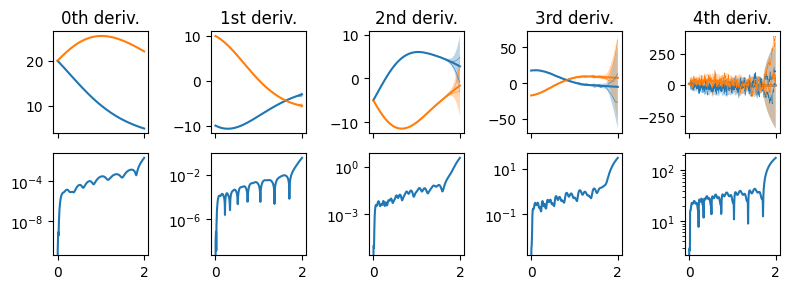

In [9]:
_, num_derivatives, _ = solution.marginals.mean.shape


fig, axes_all = plt.subplots(
    nrows=2,
    ncols=num_derivatives,
    sharex=True,
    tight_layout=True,
    figsize=(8, 3),
)

for i, axes_cols in enumerate(axes_all.T):
    ms = solution.marginals.mean[:, i, :]
    samps = samples[..., i, :]
    ls = solution.marginals.cov_sqrtm_lower[:, i, :]
    stds = jnp.sqrt(jnp.einsum("jn,jn->j", ls, ls))

    if i == 1:
        axes_cols[0].set_title(f"{i}st deriv.")
    elif i == 2:
        axes_cols[0].set_title(f"{i}nd deriv.")
    elif i == 3:
        axes_cols[0].set_title(f"{i}rd deriv.")
    else:
        axes_cols[0].set_title(f"{i}th deriv.")

    axes_cols[0].plot(solution.t, ms)
    for s in samps:
        axes_cols[0].plot(solution.t, s[..., 0], color="C0", linewidth=0.35)
        axes_cols[0].plot(solution.t, s[..., 1], color="C1", linewidth=0.35)
    for m in ms.T:
        axes_cols[0].fill_between(
            solution.t, m - 1.96 * stds, m + 1.96 * stds, alpha=0.3
        )

    axes_cols[1].semilogy(solution.t, stds)

plt.show()

The marginal standard deviations obviously show how the filter is forward-only, whereas the smoother is a global estimate.

This is why you should use a filter for terminal-value simulation and a smoother if you want "global" solutions.